In [1]:
from plots.mpltoolkit import named_colors, mpl_loc, markers, fancy_legend, load_mpl_presets
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import linregress
import numpy as np
import random
import vice
import sys
sys.path.append("..")
from src.stats import skewnormal_mode_sample, jackknife_summary_statistic
load_mpl_presets()
mpl.rcParams["axes.linewidth"] = 0.5
mpl.rcParams["figure.titlesize"] = 14
mpl.rcParams["axes.titlesize"] = 14
mpl.rcParams["axes.labelsize"] = 14
mpl.rcParams["xtick.labelsize"] = 14
mpl.rcParams["ytick.labelsize"] = 14
mpl.rcParams["legend.fontsize"] = 14
print(sys.version_info)

/Users/astrobeard/Work/Research/VICErepos/VICE/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


sys.version_info(major=3, minor=10, micro=2, releaselevel='final', serial=0)


In [2]:
columns = ["LINE", "APOGEE_ID", "RA", "DEC", "GALR", "GALPHI", "GALZ", "SNREV", "TEFF", "TEFF_ERR",
    "LOGG", "LOGG_ERR", "FE_H", "FE_H_ERR", "O_FE", "O_FE_ERR", "ASTRONN_AGE", "ASTRONN_AGE_ERR",
    "LATENT_AGE", "LATENT_AGE_ERR"]
raw = np.genfromtxt("../data/Leung2023.csv", delimiter = ',', skip_header = 1, usecols = range(len(columns)))
sample = {}
for i in range(len(columns)):
    sample[columns[i]] = [row[i] for row in raw]
sample["o_h"] = [a + b for a, b in zip(sample["O_FE"], sample["FE_H"])]
sample["o_h_err"] = [np.sqrt(a**2 + b**2) for a, b in zip(sample["O_FE_ERR"], sample["FE_H_ERR"])]
sample["absz"] = [abs(_) for _ in sample["GALZ"]]
sample = vice.dataframe(sample)
sample = sample.filter("absz", "<=", 0.5)
print(sample)

vice.dataframe{
    line -----------> [0, 1, 2, ... , 192917, 192918, 192919]
    apogee_id ------> [nan, nan, nan, ... , nan, nan, nan]
    ra -------------> [0.00285, 0.005558, 0.008802, ... , 359.993, 359.995, 359.997]
    dec ------------> [57.1732, 57.3545, 63.4631, ... , 57.0124, 57.435, 56.1633]
    galr -----------> [8.4584, 11.9539, 12.8583, ... , 10.6942, 9.3281, 9.64501]
    galphi ---------> [175.658, 153.655, 151.397, ... , 159.022, 167.511, 165.095]
    galz -----------> [-0.040749, -0.470835, 0.169356, ... , -0.358826, -0.163006, -0.265258]
    snrev ----------> [282.746, 120.295, 169.02, ... , 101.537, 232.918, 88.4561]
    teff -----------> [5031.26, 4974.6, 4681.46, ... , 4954.17, 4859.91, 4585.41]
    teff_err -------> [10.1451, 15.3109, 8.76634, ... , 15.7503, 9.05073, 11.2989]
    logg -----------> [3.45613, 2.38825, 2.24553, ... , 2.47466, 2.48069, 2.57144]
    logg_err -------> [0.0235541, 0.0355173, 0.0243345, ... , 0.0347484, 0.0240131, 0.0286862]
    fe_h ----

In [3]:
class line:

    def __init__(self, slope, intercept):
        self.slope = slope
        self.intercept = intercept

    def __call__(self, x):
        return self.slope * x + self.intercept

    def __repr__(self):
        return "line(slope = %.2e +/- %.2e, intercept = %.2e +/- %.2e, rvalue = %.2e, pvalue = %.3e)" % (
            self.slope, self.stderr, self.intercept, self.intercept_stderr,
            self.rvalue, self.pvalue)

    @classmethod
    def from_scipy_linregress(cls, result):
        obj = cls(result.slope, result.intercept)
        obj.rvalue = result.rvalue
        obj.pvalue = result.pvalue
        obj.stderr = result.stderr
        obj.intercept_stderr = result.intercept_stderr
        return obj

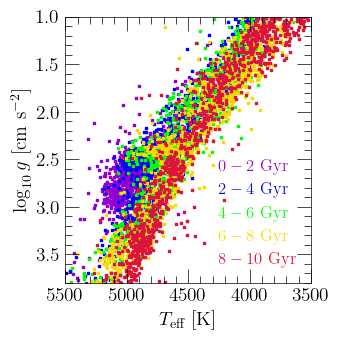

In [16]:
AGE_BINS = [0, 2, 4, 6, 8, 10]
COLORS = ["darkviolet", "blue", "lime", "gold", "crimson"]
N_SAMPLE = 1000
SEED = 1

fig = plt.figure(figsize = (3.5, 3.5))
ax = fig.add_subplot(111)
ax.set_xlabel(r"$T_\text{eff}$ [K]")
ax.set_ylabel(r"$\log_{10} g$ [cm s$^{-2}$]")
ax.set_xlim([3500, 5500])
ax.set_ylim([1, 3.8])
ax.invert_xaxis()
ax.invert_yaxis()

random.seed(a = SEED)
for i in range(len(AGE_BINS) - 1):
    sub = sample.filter(
        "astronn_age", ">=", AGE_BINS[i]).filter(
        "astronn_age", "<=", AGE_BINS[i + 1])
    indices = random.sample(range(len(sub["teff"])), N_SAMPLE)
    kwargs = {
        "c": named_colors()[COLORS[i]],
        "s": 1,
        "marker": markers()["pixel"],
        "rasterized": True,
        "label": r"$%d - %d$ Gyr" % (AGE_BINS[i], AGE_BINS[i + 1])
    }
    teff = [sub["teff"][idx] for idx in indices]
    logg = [sub["logg"][idx] for idx in indices]
    ax.scatter(teff, logg, **kwargs)

kwargs = {
    "loc": mpl_loc("lower right"),
    "handlelength": 0,
    "fontsize": 12,
    "ncol": 1
}
leg = ax.legend(**kwargs)
fancy_legend(leg, COLORS)

plt.tight_layout()
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./empirical/kiel-diagram.%s" % (ext), **kwargs)
plt.show()

In [3]:
OUTFILE = "./empirical/skewnormfits-binned-by-radius.out"
RGAL_BINS = list(range(16))

def percentiles(arr):
    ordered = np.sort(arr)
    return [ordered[int(0.16 * len(ordered))], ordered[int(0.84 * len(ordered))]]

with open(OUTFILE, 'w') as out:
    out.write("# Rgal_min [kpc]    Rgal_max [kpc]    ")
    out.write("mode([O/H])    mode([O/H])_err    ")
    out.write("[O/H]_16th    [O/H]_84th    ")
    out.write("mode([Fe/H])    mode([Fe/H])_err    ")
    out.write("[Fe/H]_16th    [Fe/H]_84th\n")
    for i in range(len(RGAL_BINS) - 1):
        sys.stdout.write("\ri = %d    " % (i))
        sub = sample.filter(
            "galr", ">=", RGAL_BINS[i]).filter(
            "galr", "<=", RGAL_BINS[i + 1])
        mode_oh = skewnormal_mode_sample(sub["o_h"])
        mode_oh_err = jackknife_summary_statistic(sub["o_h"], skewnormal_mode_sample, n_resamples = 25)
        oh_16th, oh_84th = percentiles(sub["o_h"])
        mode_feh = skewnormal_mode_sample(sub["fe_h"])
        mode_feh_err = jackknife_summary_statistic(sub["fe_h"], skewnormal_mode_sample, n_resamples = 25)
        feh_16th, feh_84th = percentiles(sub["fe_h"])
        out.write("%.3e\t%.3e\t" % (RGAL_BINS[i], RGAL_BINS[i + 1]))
        out.write("%.3e\t%.3e\t" % (mode_oh, mode_oh_err))
        out.write("%.3e\t%.3e\t" % (oh_16th, oh_84th))
        out.write("%.3e\t%.3e\t" % (mode_feh, mode_feh_err))
        out.write("%.3e\t%.3e\n" % (feh_16th, feh_84th))
    sys.stdout.write("\n")
    out.close()

i = 14    


In [4]:
def boxcarsmoothdist(arr, xvals, window):
    dist = len(xvals) * [0.]
    for i in range(len(xvals)):
        within_window = list(filter(lambda x: xvals[i] - window <= x <= xvals[i] + window, arr))
        dist[i] = len(within_window)
    norm = 0
    for i in range(len(dist) - 1): norm += dist[i] * (xvals[i + 1] - xvals[i])
    return [_ / norm for _ in dist]

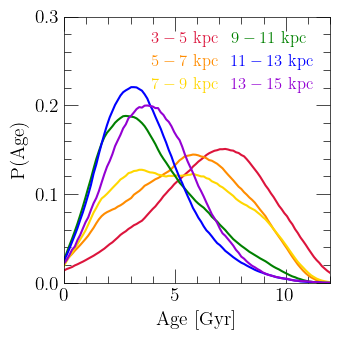

In [5]:
RADIAL_BINS = [3, 5, 7, 9, 11, 13, 15]
COLORS = ["crimson", "darkorange", "gold", "green", "blue", "darkviolet"]

fig = plt.figure(figsize = (3.5, 3.5))
ax = fig.add_subplot(111)
ax.set_xlabel(r"Age [Gyr]")
ax.set_ylabel(r"P(Age)")
ax.set_xlim([0, 12])
ax.set_ylim([0, 0.3])
ax.set_yticks([0, 0.1, 0.2, 0.3])

xvals = np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 100)
for i in range(len(RADIAL_BINS) - 1):
    sub = sample.filter(
        "galr", ">=", RADIAL_BINS[i]).filter(
        "galr", "<=", RADIAL_BINS[i + 1]).filter(
        "astronn_age_err", ">=", 0)
    dist = boxcarsmoothdist(sub["astronn_age"], xvals, np.median(sub["astronn_age_err"]))
    kwargs = {
        "c": named_colors()[COLORS[i]],
        "label": r"$%d - %d$ kpc" % (RADIAL_BINS[i], RADIAL_BINS[i + 1])
    }
    ax.plot(xvals, dist, **kwargs)

kwargs = {
    "loc": mpl_loc("upper right"),
    "handlelength": 0,
    "ncol": 2,
    "columnspacing": 0.5,
    "fontsize": 12
}
leg = ax.legend(**kwargs)
fancy_legend(leg, COLORS)

plt.tight_layout()
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./empirical/age-dists.%s" % (ext), **kwargs)
plt.show()

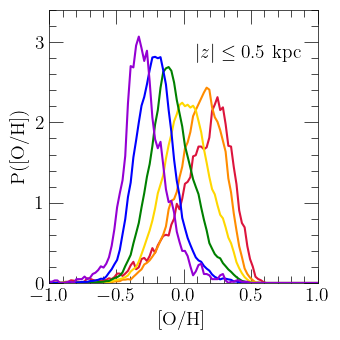

In [6]:
ELEMENT = "o"
RADIAL_BINS = [3, 5, 7, 9, 11, 13, 15]
COLORS = ["crimson", "darkorange", "gold", "green", "blue", "darkviolet"]

fig = plt.figure(figsize = (3.5, 3.5))
ax = fig.add_subplot(111)
ax.set_xlabel("[%s/H]" % (ELEMENT.capitalize()))
ax.set_ylabel("P([%s/H])" % (ELEMENT.capitalize()))
ax.set_xlim([-1, 1])
ax.set_ylim([0, 3.4])
ax.set_yticks([0, 1, 2, 3])
ax.text(0.1, 2.8, r"$\left| z \right| \leq 0.5$ kpc", fontsize = 14)

xvals = np.linspace(ax.get_xlim()[0], ax.get_xlim()[1], 100)
with open("./empirical/%sh-dists.out" % (ELEMENT.lower()), 'w') as out:
    out.write("# Rgal_min [kpc]    Rgal_max [kpc]    ")
    out.write("[O/H]    P([O/H])\n")
    for i in range(len(RADIAL_BINS) - 1):
        sub = sample.filter(
            "galr", ">=", RADIAL_BINS[i]).filter(
            "galr", "<=", RADIAL_BINS[i + 1]).filter(
            "%s_h_err" % (ELEMENT.lower()), ">=", 0)
        dist = boxcarsmoothdist(sub["%s_h" %  (ELEMENT.lower())], xvals, np.median(sub["%s_h_err" % (ELEMENT)]))
        kwargs = {"c": named_colors()[COLORS[i]]}
        ax.plot(xvals, dist, **kwargs)
        for j in range(len(xvals)):
            out.write("%.3e\t%.3e\t" % (RADIAL_BINS[i], RADIAL_BINS[i + 1]))
            out.write("%.3e\t%.3e\n" % (xvals[j], dist[j]))

plt.tight_layout()
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./empirical/%sh-dists.%s" % (ELEMENT.lower(), ext), **kwargs)
plt.show()

line(slope = -3.75e-01 +/- 3.62e-02, intercept = 5.21e+00 +/- 1.57e-01, rvalue = -9.44e-01, pvalue = 1.185e-07)


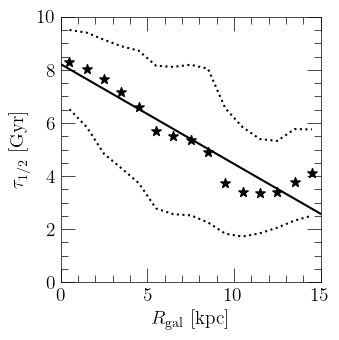

In [18]:
RADIAL_BINS = list(range(16))

fig = plt.figure(figsize = (3.5, 3.5))
ax = fig.add_subplot(111)
ax.set_xlabel(r"$R_\text{gal}$ [kpc]")
ax.set_ylabel(r"$\tau_{1/2}$ [Gyr]")
ax.set_xlim([0, 15])
ax.set_ylim([0, 10])

def percentiles(arr):
    ordered = np.sort(arr)
    sixteen = ordered[int(0.16 * len(arr))]
    eightyfour = ordered[int(0.84 * len(arr))]
    return [sixteen, np.median(arr), eightyfour]

upper = []
lower = []
medians = []
with open("./empirical/agefit.out", 'w') as out:
    out.write("# Rgal_min [kpc]    Rgal_max [kpc]    ")
    out.write("tau_16    tau_50    tau_84\n")
    for i in range(len(RADIAL_BINS) - 1):
        sub = sample.filter(
            "galr", ">=", RADIAL_BINS[i]).filter(
            "galr", "<=", RADIAL_BINS[i + 1]).filter(
            "astronn_age", ">=", 0)
        low, med, up = percentiles(sub["astronn_age"])
        upper.append(up)
        lower.append(low)
        medians.append(med)
        out.write("%.2e\t%.2e\t" % (RADIAL_BINS[i], RADIAL_BINS[i + 1]))
        out.write("%.2e\t%.2e\t%.2e\n" % (low, med, up))
    out.close()
centers = [(a + b) / 2 for a, b in zip(RADIAL_BINS[:-1], RADIAL_BINS[1:])]
kwargs = {
    "c": named_colors()["black"],
    "marker": markers()["star"],
    "s": 50
}
ax.scatter(centers, medians, **kwargs)
ax.plot(centers, lower, linestyle = ":", c = kwargs["c"])
ax.plot(centers, upper, linestyle = ":", c = kwargs["c"])

bestfit = line.from_scipy_linregress(linregress([x - 8 for x in centers], medians))
print(bestfit)
ax.plot(ax.get_xlim(), [bestfit(x - 8) for x in ax.get_xlim()], c = named_colors()["black"])

plt.tight_layout()
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./empirical/age-gradient.%s" % (ext), **kwargs)
plt.show()

line(slope = -6.20e-02 +/- 1.49e-03, intercept = 2.81e-02 +/- 6.47e-03, rvalue = -9.96e-01, pvalue = 3.191e-15)
line(slope = -7.00e-02 +/- 3.02e-03, intercept = -1.90e-02 +/- 1.32e-02, rvalue = -9.88e-01, pvalue = 5.907e-12)


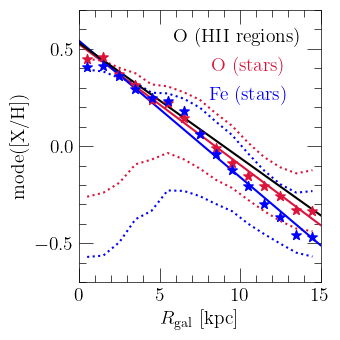

In [16]:
OUTFILE = "./empirical/skewnormfits-binned-by-radius.out"
RGAL_BINS = list(range(16))
COLORS = {
    "o": "crimson",
    "fe": "blue"
}

fig = plt.figure(figsize = (3.5, 3.5))
ax = fig.add_subplot(111)
ax.set_xlabel(r"$R_\text{gal}$ [kpc]")
ax.set_ylabel(r"mode([X/H])")
ax.set_xlim([0, 15])
ax.set_ylim([-0.7, 0.7])
ax.set_yticks([-0.5, 0, 0.5])

hii_regions = line(-0.059, np.log10(vice.solar_z.epsilon_to_z_conversion(9.22, 15.999) / vice.solar_z['o']))
kwargs = {
    "c": named_colors()["black"],
    "label": "O (HII regions)",
    "zorder": 100
}
ax.plot(ax.get_xlim(), [hii_regions(x) for x in ax.get_xlim()], **kwargs)

raw = np.genfromtxt(OUTFILE)
centers = [(a + b) / 2 for a, b in zip(raw[:, 0], raw[:, 1])]
mode_oh = raw[:, 2]
mode_oh_err = raw[:, 3]
oh_16th = raw[:, 4]
oh_84th = raw[:, 5]
mode_feh = raw[:, 6]
mode_feh_err = raw[:, 7]
feh_16th = raw[:, 8]
feh_84th = raw[:, 9]

kwargs = {
    "c": named_colors()[COLORS["o"]],
    "marker": markers()["star"],
    "s": 50,
    "zorder": 100
}
ax.scatter(centers, mode_oh, **kwargs)
kwargs["c"] = named_colors()[COLORS["fe"]]
ax.scatter(centers, mode_feh, **kwargs)

kwargs = {
    "c": named_colors()[COLORS["o"]],
    "linestyle": ":"
}
ax.plot(centers, oh_16th, **kwargs)
ax.plot(centers, oh_84th, **kwargs)
kwargs["c"] = named_colors()[COLORS["fe"]]
ax.plot(centers, feh_16th, **kwargs)
ax.plot(centers, feh_84th, **kwargs)

centers = [x - 8 for x in centers]
oh_line = line.from_scipy_linregress(linregress(centers, mode_oh))
feh_line = line.from_scipy_linregress(linregress(centers, mode_feh))
kwargs = {
    "c": named_colors()[COLORS["o"]],
    "label": "O (stars)"
}
ax.plot(ax.get_xlim(), [oh_line(x - 8) for x in ax.get_xlim()], **kwargs)
kwargs["c"] = named_colors()[COLORS["fe"]]
kwargs["label"] = "Fe (stars)"
ax.plot(ax.get_xlim(), [feh_line(x - 8) for x in ax.get_xlim()], **kwargs)
print(oh_line)
print(feh_line)

kwargs = {
    "loc": mpl_loc("upper right"),
    "handlelength": 0,
    "ncol": 1
}
leg = ax.legend(**kwargs)
fancy_legend(leg, ["black"] + [COLORS[key] for key in COLORS.keys()])
renderer = fig.canvas.get_renderer()
width = max([t.get_window_extent(renderer).width for t in leg.get_texts()])
for t in leg.get_texts():
    t.set_ha("right")
    shift = width - t.get_window_extent(renderer).width
    t.set_position((0.7 * shift, 0))

plt.tight_layout()
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./empirical/xh-gradient.%s" % (ext), **kwargs)
plt.show()

In [5]:
OUTFILE = "./empirical/skewnormfits-binned-by-age-and-radius.out"
# OUTFILE = "./empirical/skewnormfits-binned-by-latentage-and-radius.out"
RGAL_BINS = list(range(16))
AGE_BINS = list(range(11))
# AGE_BINS = list(range(0, 11, 2))
MIN_STARS = 200

with open(OUTFILE, 'w') as out:
    out.write("# age_min [Gyr]    age_max [Gyr]    ")
    out.write("Rgal_min [kpc]    Rgal_max [kpc]    ")
    out.write("mode([O/H])    mode([O/H])_err    ")
    out.write("mode([Fe/H])    mode([Fe/H])_err\n")
    for i in range(len(AGE_BINS) - 1):
        sub = sample.filter(
            "astronn_age", ">=", AGE_BINS[i]).filter(
            "astronn_age", "<=", AGE_BINS[i + 1])
#             "latent_age", ">=", AGE_BINS[i]).filter(
#             "latent_age", "<=", AGE_BINS[i + 1])
        for j in range(len(RGAL_BINS) - 1):
            subsub = sub.filter(
                "galr", ">=", RGAL_BINS[j]).filter(
                "galr", "<=", RGAL_BINS[j + 1])
            sys.stdout.write("\ri = %d ; j = %d    " % (i, j))
            if len(subsub["o_h"]) >= MIN_STARS:
                try:
                    mode_oh = skewnormal_mode_sample(subsub["o_h"])
                    mode_oh_err = jackknife_summary_statistic(subsub["o_h"], skewnormal_mode_sample, n_resamples = 25)
                except RuntimeError:
                    mode_oh = mode_oh_err = float("nan")
                try:
                    mode_feh = skewnormal_mode_sample(subsub["fe_h"])
                    mode_feh_err = jackknife_summary_statistic(subsub["fe_h"], skewnormal_mode_sample, n_resamples = 25)
                except RuntimeError:
                    mode_feh = mode_feh_err = float("nan")
            else:
                mode_oh = mode_oh_err = mode_feh = mode_feh_err = float("nan")
            out.write("%.3e\t%.3e\t" % (AGE_BINS[i], AGE_BINS[i + 1]))
            out.write("%.3e\t%.3e\t" % (RGAL_BINS[j], RGAL_BINS[j + 1]))
            out.write("%.3e\t%.3e\t" % (mode_oh, mode_oh_err))
            out.write("%.3e\t%.3e\n" % (mode_feh, mode_feh_err))
    sys.stdout.write("\n")
    out.close()

i = 9 ; j = 14    


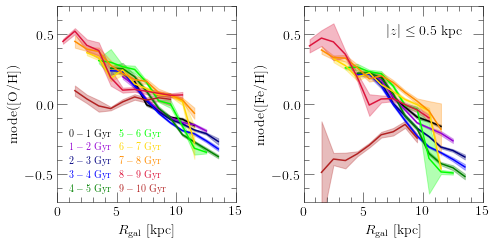

In [6]:
OUTFILE = "./empirical/skewnormfits-binned-by-age-and-radius.out"
# OUTFILE = "./empirical/skewnormfits-binned-by-latentage-and-radius.out"
RGAL_BINS = list(range(16))
AGE_BINS = list(range(11))
COLORS = ["black", "darkviolet", "navy", "blue", "green",
    "lime", "gold", "darkorange", "crimson", "firebrick"]
# AGE_BINS = list(range(0, 11, 2))
# COLORS = ["crimson", "gold", "green", "blue", "darkviolet"]

fig = plt.figure(figsize = (7, 3.5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
for ax in [ax1, ax2]:
    ax.set_xlabel(r"$R_\text{gal}$ [kpc]", fontsize = 14)
    ax.set_xlim([0, 15])
    ax.set_xticks([0, 5, 10, 15])
    ax.set_ylim([-0.7, 0.7])
    ax.set_yticks([-0.5, 0, 0.5])
ax1.set_ylabel(r"mode([O/H])", fontsize = 14)
ax2.set_ylabel(r"mode([Fe/H])", fontsize = 14)
ax2.text(7, 0.5, r"$\left| z \right| \leq 0.5$ kpc", fontsize = 14)

raw = np.genfromtxt(OUTFILE)
OH_REGRESSIONS = []
FEH_REGRESSIONS = []
for i in range(len(AGE_BINS) - 1):
    sub = []
    for row in raw:
        if row[0] == AGE_BINS[i] and row[1] == AGE_BINS[i + 1]: sub.append(row)
    rgal_min = [row[2] for row in sub]
    rgal_max = [row[3] for row in sub]
    centers = [(a + b) / 2 for a, b in zip(rgal_min, rgal_max)]
    mode_oh = [row[4] for row in sub]
    mode_oh_err = [row[5] for row in sub]
    mode_feh = [row[6] for row in sub]
    mode_feh_err = [row[7] for row in sub]
    kwargs = {
        "color": named_colors()[COLORS[i]],
        "alpha": 0.3
    }
    ax1.fill_between(centers, [a - b for a, b in zip(mode_oh, mode_oh_err)],
        [a + b for a, b in zip(mode_oh, mode_oh_err)], **kwargs)
    ax2.fill_between(centers, [a - b for a, b in zip(mode_feh, mode_feh_err)],
        [a + b for a, b in zip(mode_feh, mode_feh_err)], **kwargs)
    kwargs = {
        "c": named_colors()[COLORS[i]],
        "label": r"$%g - %g$ Gyr" % (AGE_BINS[i], AGE_BINS[i + 1])
    }
    ax1.plot(centers, mode_oh, **kwargs)
    ax2.plot(centers, mode_feh, **kwargs)
    x1 = []
    x2 = []
    y1 = []
    y2 = []
    for i in range(len(centers)):
        if not np.isnan(mode_oh[i]):
            x1.append(centers[i] - 8)
            y1.append(mode_oh[i])
        else: pass
        if not np.isnan(mode_feh[i]):
            x2.append(centers[i] - 8)
            y2.append(mode_feh[i])
        else: pass
    OH_REGRESSIONS.append(line.from_scipy_linregress(linregress(x1, y1)))
    FEH_REGRESSIONS.append(line.from_scipy_linregress(linregress(x2, y2)))

kwargs = {
    "loc": mpl_loc("lower left"),
    "handlelength": 0,
    "ncol": 2,
#     "ncol": 1,
    "fontsize": 10,
    "columnspacing": 0.5
}
leg = ax1.legend(**kwargs)
fancy_legend(leg, COLORS)

plt.tight_layout()
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./empirical/gradxh-binned-by-age.%s" % (ext), **kwargs)
#     plt.savefig("./empirical/gradxh-binned-by-latentage.%s" % (ext), **kwargs)
plt.show()

In [13]:
# for i in range(len(OH_REGRESSIONS)):
#     print(OH_REGRESSIONS[i])
# for i in range(len(FEH_REGRESSIONS)):
#     print(FEH_REGRESSIONS[i])
for i in range(len(OH_REGRESSIONS)):
    texline = "$%d - %d$ Gyr & $%.3f \pm %.3f$ kpc$^{-1}$ & $%.3f \pm %.3f$" % (
        AGE_BINS[i], AGE_BINS[i + 1], OH_REGRESSIONS[i].slope, OH_REGRESSIONS[i].stderr,
        OH_REGRESSIONS[i].intercept, OH_REGRESSIONS[i].intercept_stderr)
    print(texline)
    print(r"\\")
print("==========================")
for i in range(len(FEH_REGRESSIONS)):
    texline = "$%d - %d$ Gyr & $%.3f \pm %.3f$ kpc$^{-1}$ & $%.3f \pm %.3f$" % (
        AGE_BINS[i], AGE_BINS[i + 1], FEH_REGRESSIONS[i].slope, FEH_REGRESSIONS[i].stderr,
        FEH_REGRESSIONS[i].intercept, FEH_REGRESSIONS[i].intercept_stderr)
    print(texline)
    print(r"\\")

$0 - 2$ Gyr & $-0.051 \pm 0.007$ kpc$^{-1}$ & $0.035 \pm 0.017$
\\
$2 - 4$ Gyr & $-0.054 \pm 0.004$ kpc$^{-1}$ & $0.034 \pm 0.012$
\\
$4 - 6$ Gyr & $-0.054 \pm 0.006$ kpc$^{-1}$ & $0.038 \pm 0.014$
\\
$6 - 8$ Gyr & $-0.079 \pm 0.009$ kpc$^{-1}$ & $0.119 \pm 0.019$
\\
$8 - 10$ Gyr & $-0.034 \pm 0.010$ kpc$^{-1}$ & $0.122 \pm 0.018$
\\
$0 - 2$ Gyr & $-0.067 \pm 0.004$ kpc$^{-1}$ & $0.050 \pm 0.011$
\\
$2 - 4$ Gyr & $-0.083 \pm 0.005$ kpc$^{-1}$ & $-0.002 \pm 0.012$
\\
$4 - 6$ Gyr & $-0.072 \pm 0.010$ kpc$^{-1}$ & $0.006 \pm 0.022$
\\
$6 - 8$ Gyr & $-0.105 \pm 0.020$ kpc$^{-1}$ & $0.090 \pm 0.042$
\\
$8 - 10$ Gyr & $-0.073 \pm 0.023$ kpc$^{-1}$ & $0.114 \pm 0.039$
\\


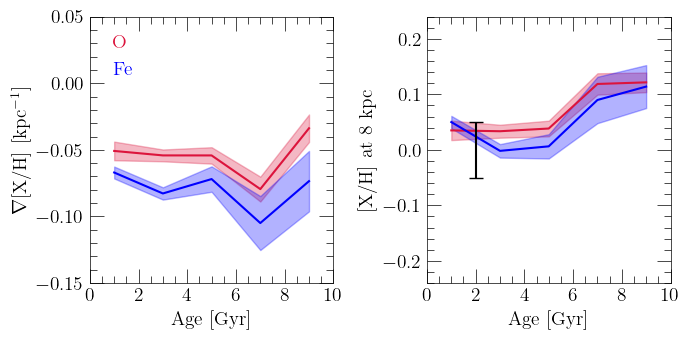

In [14]:
# FILENAME = "./empirical/skewnormfits-binned-by-age-and-radius.out"
COLORS = {
    "o": "crimson",
    "fe": "blue"
}
REGRESSIONS = {
    "o": OH_REGRESSIONS,
    "fe": FEH_REGRESSIONS
}
# BENCHMARK_RADIUS = 8 #kpc

fig = plt.figure(figsize = (7, 3.5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
for ax in [ax1, ax2]:
    ax.set_xlabel(r"Age [Gyr]")
    ax.set_xlim([0, 10])
    ax.set_xticks([0, 2, 4, 6, 8, 10])
    ax.set_ylim([-0.24, 0.24])
ax1.set_ylabel(r"$\nabla$[X/H] [kpc$^{-1}$]")
ax1.set_ylim([-0.15, 0.05])
ax2.set_ylabel(r"[X/H] at 8 kpc")

# raw = np.genfromtxt(FILENAME)
for elem in ["o", "fe"]:
    # ages = [0.5 + i for i in range(10)]
    ages = [1 + (2 * i) for i in range(5)]
    regressions = REGRESSIONS[elem]
    slopes = [regressions[_].slope for _ in range(len(ages))]
    slope_errs = [regressions[_].stderr for _ in range(len(ages))]
    norms = [regressions[_].intercept for _ in range(len(ages))]
    norm_errs = [regressions[_].intercept_stderr for _ in range(len(ages))]
    # for i in range(len(raw)):
    #     if raw[i][2] == 8:
    #         norms.append(raw[i][4 + 2 * int(elem == "fe")])
    #         norm_errs.append(raw[i][5 + 2 * int(elem == "fe")])
    #     else: pass
    # norms = [regressions[_](BENCHMARK_RADIUS) for _ in range(len(ages))]
    # norm_errs = [np.sqrt(BENCHMARK_RADIUS**2 * sigm**2 + sigb**2) for sigm, sigb in zip(
    #     [regressions[_].stderr for _ in range(len(ages))],
    #     [regressions[_].intercept_stderr for _ in range(len(ages))])]
    
    kwargs = {
        "c": named_colors()[COLORS[elem]],
        "label": elem.capitalize()
    }
    ax1.plot(ages, slopes, **kwargs)
    ax1.fill_between(ages, [a + b for a, b in zip(slopes, slope_errs)],
        [a - b for a, b in zip(slopes, slope_errs)], alpha = 0.3, color = kwargs["c"])
    ax2.plot(ages, norms, **kwargs)
    ax2.fill_between(ages, [a + b for a, b in zip(norms, norm_errs)],
        [a - b for a, b in zip(norms, norm_errs)], alpha = 0.3, color = kwargs["c"])

ax2.errorbar(2, 0, yerr = 0.05, c = named_colors()["black"])

kwargs = {
    "loc": mpl_loc("upper left"),
    "handlelength": 0,
    "ncol": 1
}
leg = ax1.legend(**kwargs)
fancy_legend(leg, [COLORS[key] for key in COLORS.keys()])

plt.tight_layout()
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    # plt.savefig("./empirical/slopes-norms-vs-age.%s" % (ext), **kwargs)
    plt.savefig("./empirical/slopes-norms-vs-latentage.%s" % (ext), **kwargs)
plt.show()

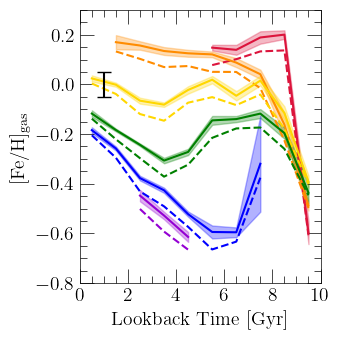

In [44]:
ELEMENT = "fe"
RADII = [3, 5, 7, 9, 11, 13]
COLORS = ["crimson", "darkorange", "gold", "green", "blue", "darkviolet"]
RAW_FILENAME = "./empirical/skewnormfits-binned-by-age-and-radius.out"
LEGEND = False

fig = plt.figure(figsize = (3.5, 3.5))
ax = fig.add_subplot(111)
ax.set_xlabel("Lookback Time [Gyr]")
ax.set_ylabel(r"[%s/H]$_\text{gas}$" % (ELEMENT.capitalize()))
ax.set_xlim([0, 10])
ax.set_xticks([0, 2, 4, 6, 8, 10])

### OXYGEN ###
ax.set_ylim([-0.8, 0.6])

### IRON
ax.set_ylim([-0.8, 0.3])

if LEGEND:
    line1 = ax.plot([-1, -2], [-1, -2], c = named_colors()["black"], label = "Eq.")[0]
    line2 = ax.plot([-1, -2], [-1, -2], c = named_colors()["black"], label = "Sub-Eq.", linestyle = "--")[0]
    kwargs = {
        "loc": mpl_loc("lower left"),
        "bbox_to_anchor": (0.02, 0.02),
        "handlelength": 1.5,
        "ncol": 1,
        "fontsize": 12
    }
    leg = ax.legend(**kwargs)
    line1.remove()
    line2.remove()
    ax.add_artist(leg)
else: pass

raw = np.genfromtxt(RAW_FILENAME)
for j in range(len(RADII)):
    ages = []
    mode = []
    err = []
    delta = []
    subdelta = []
    corr = np.genfromtxt("./rbirth-oh-distributions/mode-%sh-ism-1Gyr-bins.out" % (ELEMENT))
    subcorr = np.genfromtxt("./rbirth-oh-distributions/mode-%sh-ism-subeq-corrections.out" % (ELEMENT))
    for i in range(len(raw)):
        if raw[i][2] == RADII[j]:
            ages.append((raw[i][0] + raw[i][1]) / 2)
            mode.append(raw[i][4 + 2 * int(ELEMENT == "fe")])
            err.append(raw[i][5 + 2 * int(ELEMENT == "fe")])
        else: pass
    for i in range(len(corr)):
        if corr[i][2] == 8: delta.append(corr[i][-1] - corr[i][-2])
    for i in range(len(subcorr)):
        if subcorr[i][2] == 8: subdelta.append(subcorr[i][-1] - subcorr[i][-2])
    ism = [a + b for a, b in zip(mode, delta)]
    ax.plot(ages, ism, c = named_colors()[COLORS[j]], label = "%d kpc" % (RADII[j]))
    ax.fill_between(ages, [a + b for a, b in zip(ism, err)], [a - b for a, b in zip(ism, err)],
        color = named_colors()[COLORS[j]], alpha = 0.3)
    ism = [a + b for a, b in zip(mode, subdelta)]
    ax.plot(ages, ism, c = named_colors()[COLORS[j]], linestyle = "--")

ax.errorbar(1, 0, yerr = 0.05, color = named_colors()["black"])

if LEGEND:
    kwargs = {
        "loc": mpl_loc("upper left"),
        "handlelength": 0,
        "ncol": 2,
        "columnspacing": 0.5,
        "fontsize": 12
    }
    leg = ax.legend(**kwargs)
    fancy_legend(leg, COLORS)
else: pass

plt.tight_layout()
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./empirical/%sh-ism-vs-age.%s" % (ELEMENT.lower(), ext), **kwargs)
plt.show()

What are the slopes and intercepts for $\leq 9$ Gyr old populations?
--

In [26]:
RGAL_BINS = list(range(16))

sub = sample.filter("astronn_age", "<=", 9)
mode_oh = []
mode_feh = []
for i in range(len(RGAL_BINS) - 1):
    subsub = sub.filter(
        "galr", ">=", RGAL_BINS[i]).filter(
        "galr", "<=", RGAL_BINS[i + 1])
    mode_oh.append(skewnormal_mode_sample(subsub["o_h"]))
    mode_feh.append(skewnormal_mode_sample(subsub["fe_h"]))
centers = [(a + b) / 2 - 8 for a, b in zip(RGAL_BINS[:-1], RGAL_BINS[1:])]
# print(centers)
# print(mode_oh)
# print(mode_feh)
# oh_grad = line.from_scipy_linregress(linregress(centers, mode_oh))
# feh_grad = line.from_scipy_linregress(linregress(centers, mode_feh))
oh_grad = linregress(centers, mode_oh)
feh_grad = linregress(centers, mode_feh)

print(oh_grad)
print(feh_grad)

LinregressResult(slope=-0.06182046352786065, intercept=0.028430323360922383, rvalue=-0.9957824532440508, pvalue=7.10951524665587e-15, stderr=0.0015797292683976732, intercept_stderr=0.006870763030437499)
LinregressResult(slope=-0.06839887587231944, intercept=-0.02315349858505731, rvalue=-0.9856992031241575, pvalue=1.9423017173283823e-11, stderr=0.003243170137038694, intercept_stderr=0.014105615389139545)


In [5]:
# values taken from Di Teodoro & Peek (2021)
vrad25 = [2, 4, -6, 5, -4, 4, 4, -8, -3, 0, 9, -3, -1, -3, -5,
          0, -2, 0, 0, 1, -7, 6, -3, 9, 1, 8, 5, -4, 0, -6, -11,
          -7, 1, -2, -4, -12, 0, 7, 10, 7, -7, 0, -4, 5, -7, -2,
          -1, 0, -1, -1, -5, 5, -5, 8]
vrad25_err = [3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 3, 3, 3,
              3, 3, 3, 3, 4, 3, 4, 4, 3, 3, 3, 3, 3, 3, 4, 3, 5, 4,
              3, 3, 3, 3, 3, 4, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4]
vradhi = [0, float("nan"), -7, float("nan"), -16, 7, 7, -13, -3, 2,
          21, -3, float("nan"), -6, -22, 2, -4, float("nan"), 1, 6,
          -6, float("nan"), -17, float("nan"), 1, 11, 6, 0, 0, -6, -12,
          float("nan"), float("nan"), -3, -2, float("nan"), 1,
          float("nan"), 19, 7, -7, -1, -5, 16, -1, -1, 0, 0, -2, -3,
          -5, 4, float("nan"), 9]
vradhi_err = [3, float("nan"), 4, float("nan"), 4, 3, 3, 4, 3, 5, 3, 3,
              float("nan"), 4, 5, 4, 4, float("nan"), 4, 5, 3, float("nan"),
              5, float("nan"), 3, 3, 4, 4, 4, 4, 4, float("nan"), float("nan"),
              4, 3, float("nan"), 4, float("nan"), 3, 3, 3, 3, 2, 3, 3, 3, 4, 3,
              3, 4, 3, 3, float("nan"), 4]

3.185185185185185
3.558139534883721


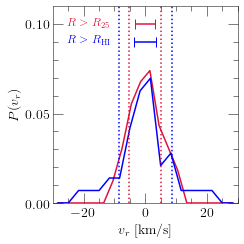

In [6]:
fig = plt.figure(figsize = (3.5, 3.5))
ax = fig.add_subplot(111)
ax.set_xlabel(r"$v_r$ [km/s]")
ax.set_ylabel(r"$P(v_r)$")
ax.set_xlim([-30, 30])
ax.set_ylim([0, 0.11])
ax.set_yticks([0, 0.05, 0.1])

vradhi = list(filter(lambda x: not np.isnan(x), vradhi))
vradhi_err = list(filter(lambda x: not np.isnan(x), vradhi_err))

def plot_distribution(arr, hist_kwargs = {}, plot_kwargs = {}):
    counts, bins = np.histogram(arr, **hist_kwargs)
    centers = [(a + b) / 2 for a, b in zip(bins[:-1], bins[1:])]
    ax.plot(centers, counts, **plot_kwargs)
    # ax.step(bins[:-1], counts, where = "post", **plot_kwargs)

plot_distribution(vrad25, hist_kwargs = {
    "bins": 20,
    "range": ax.get_xlim(),
    "density": True
}, plot_kwargs = {
    "c": named_colors()["crimson"],
    "label": r"$R > R_{25}$"
})
plot_distribution(vradhi, hist_kwargs = {
    "bins": 18,
    "range": ax.get_xlim(),
    "density": True
}, plot_kwargs = {
    "c": named_colors()["blue"],
    "label": r"$R > R_\text{HI}$"
})

kwargs = {
    "loc": mpl_loc("upper left"),
    "handlelength": 0,
    "fontsize": 12
}
leg = ax.legend(**kwargs)
fancy_legend(leg, ["crimson", "blue"])

ax.errorbar(0, 0.1, xerr = np.mean(vrad25_err), c = named_colors()["crimson"])
ax.axvline(np.std(vrad25), c = named_colors()["crimson"], linestyle = ":")
ax.axvline(-np.std(vrad25), c = named_colors()["crimson"], linestyle = ":")
ax.errorbar(0, 0.09, xerr = np.mean(vradhi_err), c = named_colors()["blue"])
ax.axvline(np.std(vradhi), c = named_colors()["blue"], linestyle = ":")
ax.axvline(-np.std(vradhi), c = named_colors()["blue"], linestyle = ":")

# ax.text(5, 0.1, r"$\langle v_r \rangle = %.1f$ km/s" % (np.median(vrad25)),
#     color = named_colors()["crimson"], fontsize = 12)
# ax.text(5, 0.09, r"$\langle v_r \rangle = %.1f$ km/s" % (np.median(vradhi)),
#     color = named_colors()["blue"], fontsize = 12)
print(np.mean(vrad25_err))
print(np.mean(vradhi_err))

plt.tight_layout()
for ext in ["pdf", "jpeg"]:
    kwargs = {}
    if ext == "jpeg": kwargs["dpi"] = 200
    plt.savefig("./empirical/vr-observed-dist.%s" % (ext), **kwargs)
plt.show()